### R-CNN Method

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

def load_model():
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    return model

def detect_faces(image, model, threshold=0.95):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = F.to_pil_image(image)
    tensor_image = F.to_tensor(pil_image).unsqueeze(0)
    with torch.no_grad():
        predictions = model(tensor_image)
    high_scores = predictions[0]['scores'] > threshold  # Increase threshold to reduce false positives
    boxes = predictions[0]['boxes'][high_scores].data.numpy()
    return boxes

def calculate_movement(faceCenter, prevCenter):
    if prevCenter is None:
        return 0
    return np.sqrt((faceCenter[0] - prevCenter[0])**2 + (faceCenter[1] - prevCenter[1])**2)

def r_cnn_model(video_path):
    model = load_model()
    cap = cv2.VideoCapture(video_path)
    prevCenter = None
    total_movement = 0
    movements = []
    frame_count = 0
    successful_detections = 0

    plt.ion()
    fig, ax = plt.subplots()
    line, = ax.plot(movements)
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 100)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        boxes = detect_faces(frame, model)
        if len(boxes) > 0:
            successful_detections += 1
            x, y, w, h = boxes[0][:4]
            currentCenter = ((x + w) / 2, (y + h) / 2)
            cv2.rectangle(frame, (int(x), int(y)), (int(w), int(h)), (255, 0, 0), 2)  # Draw the rectangle
            if prevCenter is not None:
                movement = calculate_movement(currentCenter, prevCenter)
                total_movement += movement
                movements.append(total_movement)
                line.set_data(range(len(movements)), movements)
                ax.relim()
                ax.autoscale_view()
                plt.draw()
            prevCenter = currentCenter

        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    plt.ioff()
    plt.show()
    cap.release()
    cv2.destroyAllWindows()

    print("Total frames processed:", frame_count)
    print("Successfully detected frames:", successful_detections)
    print("Detection success rate: {:.2f}%".format((successful_detections / frame_count) * 100 if frame_count > 0 else 0))




#### Training

In [17]:
import cv2
import numpy as np
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import pandas as pd
import os

def load_model():
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    return model

def load_annotations(csv_path, base_image_path):
    """ Load annotations and convert landmarks to bounding boxes. """
    df = pd.read_csv(csv_path)
    bounding_boxes = {}
    for _, row in df.iterrows():
        # Create the full path to the image using the 'image-set' folder and 'filename'
        image_path = os.path.join(base_image_path, row['image-set'], row['filename'])
        # Extract and create bounding boxes from landmarks
        xs = [row[f'gt-x{i}'] for i in range(68)]
        ys = [row[f'gt-y{i}'] for i in range(68)]
        bbox = [min(xs), min(ys), max(xs), max(ys)]
        bounding_boxes[image_path] = bbox
    return bounding_boxes


def detect_faces(image, model, threshold=0.8):
    """ Detect faces using the R-CNN model on a given image. """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = F.to_pil_image(image)
    tensor_image = F.to_tensor(pil_image).unsqueeze(0)
    with torch.no_grad():
        predictions = model(tensor_image)
    high_scores = predictions[0]['scores'] > threshold
    boxes = predictions[0]['boxes'][high_scores].numpy()
    return boxes

def bb_intersection_over_union(boxA, boxB):
    """ Calculate the Intersection over Union (IoU) of two bounding boxes. """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def evaluate_model(image_directory, annotations, model):
    """ Evaluate the model on images with their corresponding ground truths. """
    iou_scores = []
    for image_path, gt_bbox in annotations.items():
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image at {image_path}")
            continue
        predicted_boxes = detect_faces(image, model)
        for pred_bbox in predicted_boxes:
            iou = bb_intersection_over_union(pred_bbox, gt_bbox)
            iou_scores.append(iou)
    
    average_iou = np.mean(iou_scores) if iou_scores else 0
    print(f"Average IoU: {average_iou:.4f}")


def evaluate_detections(gt_boxes, pred_boxes):
    tp = sum(1 for pred in pred_boxes if any(bb_intersection_over_union(pred, gt) >= 0.5 for gt in gt_boxes))
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1


In [18]:
model = load_model()
base_image_path = './images'
annotations = load_annotations('labels.csv', base_image_path)
evaluate_model(base_image_path, annotations, model)


/Users/noh/venv-metal/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/noh/venv-metal/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: kno

Average IoU: 0.1543


#### Test 1

KeyboardInterrupt: 

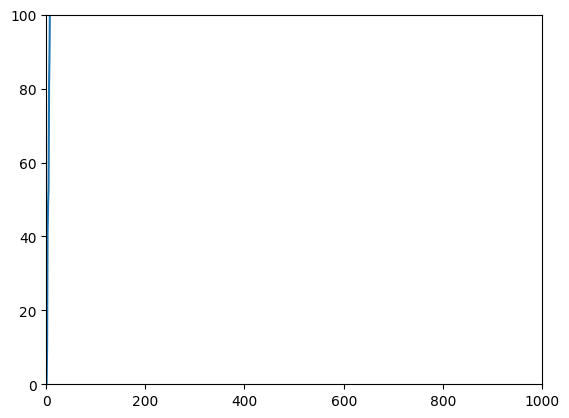

In [46]:
r_cnn_model('test_video_2.mp4')

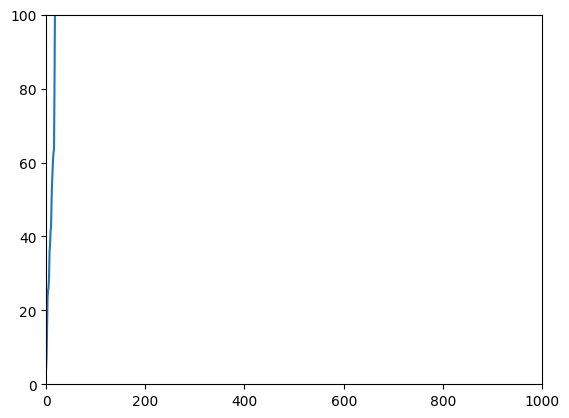

Total frames processed: 1701
Successfully detected frames: 1626
Detection success rate: 95.59%


In [38]:
r_cnn_model('test_video_3.mp4')

### HAAR Cascade (Face+Eye) Method

In [39]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def detect_faces_and_eyes(gray_frame):
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=4, flags=cv.CASCADE_SCALE_IMAGE, minSize=(20, 20))
    eyes_detected = []
    for (x, y, w, h) in faces:
        face_roi = gray_frame[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(face_roi)
        eyes_detected.append((eyes, (x, y, w, h)))
    return faces, eyes_detected

def draw_faces_and_eyes(frame, faces, eyes_detected):
    for (x, y, w, h) in faces:
        center = (x + w//2, y + h//2)
        frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        for (eyes, (fx, fy, fw, fh)) in eyes_detected:
            for (ex, ey, ew, eh) in eyes:
                eye_center = (fx + ex + ew//2, fy + ey + eh//2)
                radius = int(round((ew + eh) * 0.25))
                frame = cv.circle(frame, eye_center, radius, (255, 0, 0), 4)
    return frame

def calculate_movement(center, prev_center):
    if prev_center is None:
        return 0
    return np.sqrt((center[0] - prev_center[0])**2 + (center[1] - prev_center[1])**2)

def haar_eye(video_path):
    cap = cv.VideoCapture(video_path)
    prev_center = None
    total_movement = 0
    movements = []
    frame_count = 0
    successful_detections = 0

    plt.ion()
    fig, ax = plt.subplots()
    line, = ax.plot(movements)
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 100)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        faces, eyes_detected = detect_faces_and_eyes(gray)

        if len(faces) > 0:
            successful_detections += 1
            x, y, w, h = faces[0]
            current_center = (x + w//2, y + h//2)
            if prev_center is not None:
                movement = calculate_movement(current_center, prev_center)
                total_movement += movement
                movements.append(total_movement)
                line.set_data(range(len(movements)), movements)
                ax.relim()
                ax.autoscale_view()
                plt.draw()
            prev_center = current_center
        
        frame = draw_faces_and_eyes(frame, faces, eyes_detected)
        cv.imshow('Frame', frame)
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    plt.ioff()
    plt.show()
    cap.release()
    cv.destroyAllWindows()

    print("Total frames processed:", frame_count)
    print("Successfully detected frames:", successful_detections)
    print("Detection success rate: {:.2f}%".format((successful_detections / frame_count) * 100))

# Load the cascades
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')
eyes_cascade = cv.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')


#### Test 1

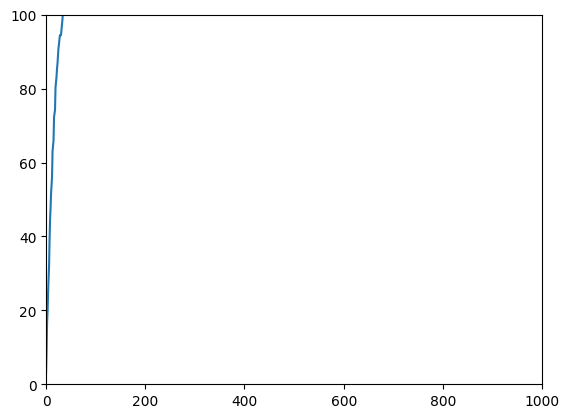

Total frames processed: 652
Successfully detected frames: 308
Detection success rate: 47.24%


In [40]:
haar_eye('test_video_2.mp4')

#### Test 2

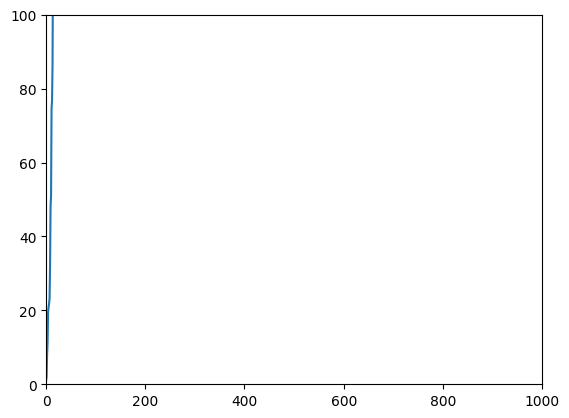

Total frames processed: 1701
Successfully detected frames: 201
Detection success rate: 11.82%


In [41]:
haar_eye('test_video_3.mp4')

### HAAR Cascade (Face) Method

In [26]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def detect_faces(gray_frame):
    return face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=4, flags=cv.CASCADE_SCALE_IMAGE, minSize=(20, 20))

def draw_faces(frame, faces):
    for (x, y, w, h) in faces:
        center = (x + w//2, y + h//2)
        frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
    return frame

def calculate_movement(center, prev_center):
    if prev_center is None:
        return 0
    return np.sqrt((center[0] - prev_center[0])**2 + (center[1] - prev_center[1])**2)

def haar(video_path):
    cap = cv.VideoCapture(video_path)
    prev_center = None
    total_movement = 0
    movements = []
    frame_count = 0
    successful_detections = 0

    plt.ion()
    fig, ax = plt.subplots()
    line, = ax.plot(movements)
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 100)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        faces = detect_faces(gray)

        if len(faces) > 0:
            successful_detections += 1
            x, y, w, h = faces[0]
            current_center = (x + w//2, y + h//2)
            if prev_center is not None:
                movement = calculate_movement(current_center, prev_center)
                total_movement += movement
                movements.append(total_movement)
                line.set_data(range(len(movements)), movements)
                ax.relim()
                ax.autoscale_view()
                plt.draw()
            prev_center = current_center
        
        frame = draw_faces(frame, faces)
        cv.imshow('Frame', frame)
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    plt.ioff()
    plt.show()
    cap.release
    cv.destroyAllWindows()

    print("Total frames processed:", frame_count)
    print("Successfully detected frames:", successful_detections)
    print("Detection success rate: {:.2f}%".format((successful_detections / frame_count) * 100))

# Load the cascades
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')


#### Test 1

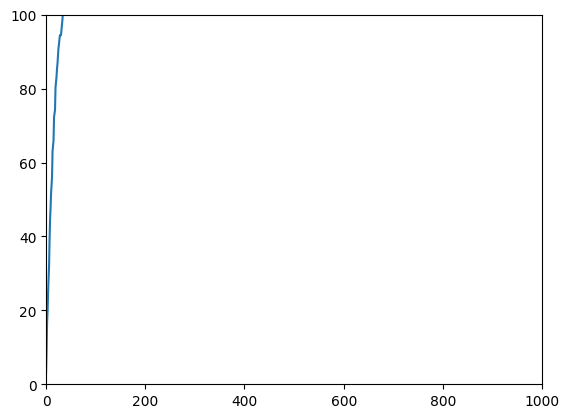

Total frames processed: 652
Successfully detected frames: 308
Detection success rate: 47.24%


In [28]:
haar('test_video_2.mp4')

#### Test 2

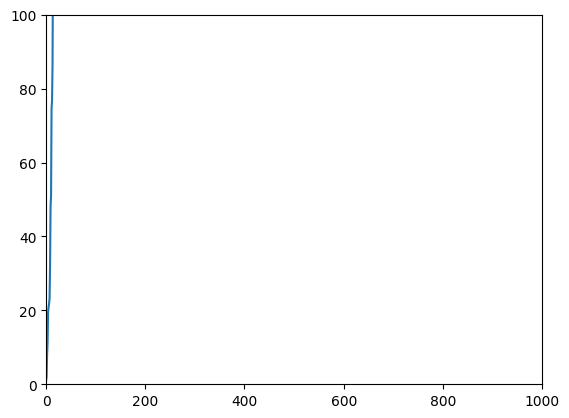

Total frames processed: 1701
Successfully detected frames: 201
Detection success rate: 11.82%


In [29]:
haar('test_video_3.mp4')

### Haar+CSRT

In [42]:
import cv2 as cv
import sys

def initialize_tracker(frame, face_cascade, eyes_cascade):
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Check each detected face for eyes to confirm it's likely the front of a head
    for (x, y, w, h) in faces:
        face_roi = gray[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(face_roi, scaleFactor=1.1, minNeighbors=5)
        if len(eyes) >= 1:  # Assuming at least one eye is visible
            return (x, y, w, h), True
    return None, False

def haar_csrt(video_path):
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eyes_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')

    if face_cascade.empty() or eyes_cascade.empty():
        print('--(!)Error loading cascades')
        sys.exit(1)

    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        print("--(!)Error opening video capture")
        sys.exit(1)

    tracker = cv.TrackerCSRT_create()
    tracker_initialized = False
    frame_count = 0
    tracking_success_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("--(!)No captured frame -- Break!")
            break

        frame_count += 1

        if not tracker_initialized:
            bbox, success = initialize_tracker(frame, face_cascade, eyes_cascade)
            if success:
                tracker.init(frame, bbox)
                tracker_initialized = True
                print("Tracker initialized.")
        else:
            # Update tracker and get the new position of the object
            success, bbox = tracker.update(frame)
            if success:
                tracking_success_count += 1
                p1 = (int(bbox[0]), int(bbox[1]))
                p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
                cv.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
            else:
                cv.putText(frame, "Tracking failure detected", (100, 80), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

        cv.imshow("Tracking", frame)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

    # Output statistics after the video is complete
    if frame_count > 0:
        success_rate = (tracking_success_count / frame_count) * 100
        print("Total frames processed: {}".format(frame_count))
        print("Successfully tracked frames: {}".format(tracking_success_count))
        print("Tracking success rate: {:.2f}%".format(success_rate))
    else:
        print("No frames were processed.")


#### Test 1

In [43]:
haar_csrt('test_video_2.mp4')

Tracker initialized.
--(!)No captured frame -- Break!
Total frames processed: 652
Successfully tracked frames: 627
Tracking success rate: 96.17%


#### Test 2

In [44]:
haar_csrt('test_video_3.mp4')

Tracker initialized.
--(!)No captured frame -- Break!
Total frames processed: 1701
Successfully tracked frames: 1700
Tracking success rate: 99.94%
